# Executive Summary

**Project Goal:** To engineer an autonomous agent capable of surviving the "Potato Phase" of the *Cuphead* boss fight by evaluating two competing neural architectures: Object Detection (YOLO + MLP) versus Latent Representation (AE + GRU).

**The Challenge:**
Previous work utilizing a general Autoencoder-Recurrent Network (Assignment 2) achieved high global accuracy (~96%) but failed functionally during gameplay. The model suffered from **Extreme Class Imbalance**, defaulting to a trivial "spam-shooting" strategy while failing to detect small, high-velocity projectiles within the compressed latent space. This project pivots from general gameplay imitation to a focused **micro-timing analysis**, isolating the specific reaction mechanics required to dodge projectiles in the "Potato" boss phase.

**Methodology:**
I designed two distinct imitation learning pipelines to determine which architecture best handles sparse-reward reaction tasks:
1.  **Pipeline A** A YOLOv8 vision model identifies semantic objects and passes a structured physics vector to a weighted Multi-Layer Perceptron (MLP).
2.  **Pipeline B:** A retrained Autoencoder compresses raw pixels into a latent manifold, which is fed into a Gated Recurrent Unit (GRU) for sequence modeling.

**Key Findings:**
*   Pipeline A (YOLO) successfully decoupled the optimal action from the human input's performance. In stress tests (Session 9), where the human player panicked and took damage, Pipeline A continued to predict valid jump commands based on projectile physics ($Distance < Threshold$).
*   Pipeline B (AE+GRU) aligned with human-like behavior but ultimately memorized the demonstrator's failures. When the human failed to jump, the GRU also failed to jump, proving it learned the *sequence* of the video rather than the *rule* of the game.
*   Standard classification thresholds (0.5) proved fatal for both models. Optimization for the **F0.8-Score** (prioritizing Precision) revealed that Pipeline A required a strict threshold (0.78) to filter noise, while Pipeline B required a loose threshold (0.36) to compensate for latent blur.

**Conclusion:**
While Pipeline B (Implicit) mimics the "style" of a human player better, **Pipeline A (Explicit/YOLO)** is the superior architecture for autonomous survival. By explicitly extracting semantic features, it eliminates the "Black Box" problem, allowing the agent to react to the *state of the game* rather than the *memory of the training data*.

# 1. Introduction

## 1.1 Project Objective
Building on previous research into whole-game behavioral cloning, this project pivots to a more granular and practical objective: **Training an autonomous agent capable of surviving the "Potato Phase" in *Cuphead*.**

Rather than asking "Can a model play the whole game?", this experiment poses a specific engineering question regarding reaction mechanics:
> *Does Explicit Perception (Object Detection) outperform Implicit Perception (Latent Representation) in high-speed reaction tasks?*

The goal is to survive the deterministic but visually demanding "Potato" boss phase by correctly identifying and dodging projectile threats (dirt clods).

## 1.2 Improvements from the Previous Assignment
In **Assignment 2**, the "General Cuphead Agent" utilized a standard Autoencoder + LSTM architecture trained on the full boss fight. While the model achieved high binary accuracy (~96%), a post-mortem analysis revealed three critical failures:
1.  Small, high-velocity projectiles were lost during image compression ($1280 \times 720 \to 128 \times 72$), making them invisible to the decision layer.
2.  The model prioritized the majority class ("Shoot"), ignoring the rare but critical "Jump" action (2.9% prevalence).
3.  The agent did not know *why* it was jumping, only that "jumping" usually happened at specific timestamps in the video.

To address these limitations, this assignment introduces **Explicit Feature Engineering**. Instead of relying on a neural network to implicitly figure out what pixels matter, I explicitly teach it to recognize threats using computer vision (YOLO) and calculate reaction logic based on extracted physics data.

## 1.3 The Two Pipelines
To determine the optimal architecture for survival, I implemented and evaluated two distinct pipelines:

*   **Pipeline A: **YOLOv8 (Vision) + MLP (Decision)**
    *   *Hypothesis:* Decoupling vision from decision-making allows the agent to generalize better and correct human errors. By calculating the projectile's velocity explicitly ($v = \Delta x / \Delta t$) from bounding boxes, a simple Feed-Forward Network (MLP) should be sufficient to map the state vector $[x, y, v_x, v_y]$ to the action `JUMP`.

*   **Pipeline B: Autoencoder (Vision) + GRU (Decision)**
    *   *Hypothesis:* This represents the "End-to-End" Deep Learning approach. The model is not told what a "bullet" is; it must learn to represent valid game states in a latent vector $z$. I utilize a Gated Recurrent Unit (GRU) with **Sigmoid Focal Loss** to better handle the vanishing gradients and class imbalance that plagued the LSTM in the previous assignment.

## 2. Data Collection and Pre-processing

### 2.1 Main Challenge
The raw data collected in the previous experiment consisted of 15 contiguous gameplay sessions recorded in a single video file. This presented a significant noise challenge: the recording contained loading screens, menu navigations, and three distinct boss phases (Potato, Onion, Carrot), each requiring different visual recognition patterns and reflex strategies.

To train a specialized agent, I needed to isolate the **Potato Phase**—the specific segment where the player must dodge projectiles (dirt clods) and jump over obstacles.
I created segmentation script and filtered dataset genreator to solve this problem 
# (see appendix X)


## 3. Pipeline A: YOLO + MLP


### **3.1 Concept**
1.  **Visual State Estimation (YOLOv8):** A computer vision model responsible for extracting semantic entities (Cuphead, Potato, Projectile) from the scene.
2.  **Control Policy (MLP):** A decision-making network that operates on a low-dimensional state vector derived from the vision layer.

**Scientific Rationale:**
In standard Behavioral Cloning, a model failure is opaque—it is difficult to determine if the agent failed because it didn't "see" the threat or because it didn't know "what to do" with the information. This architecture enables precise **Error Attribution**, allowing us to isolate perceptual failures (e.g., object detection misses) from control policy errors (e.g., incorrect action timing). Furthermore, by converting high-dimensional pixel data into explicit physics coordinates, we drastically reduce the dimensionality of the input space for the decision model.

### **3.2 Mathematical Underpinnings**

#### **3.2.1 Dataset Pre-processing**
To construct the object detection dataset, I utilized a **Uniform Random Sampling** strategy rather than sequential extraction. I extracted 60 discrete frames distributed across the 15 sessions. This ensures the model learns to generalize across different states of the boss fight rather than memorizing a specific sequence. Then, these 60 frames were annotated in Roboflow with three semantic classes: `Cuphead`, `Potato`, and `Projectile` (See Appendix B for random extraction code). the labeled dataset was stratified into a **Training Set (80%)** and a **Validation Set (20%)**.

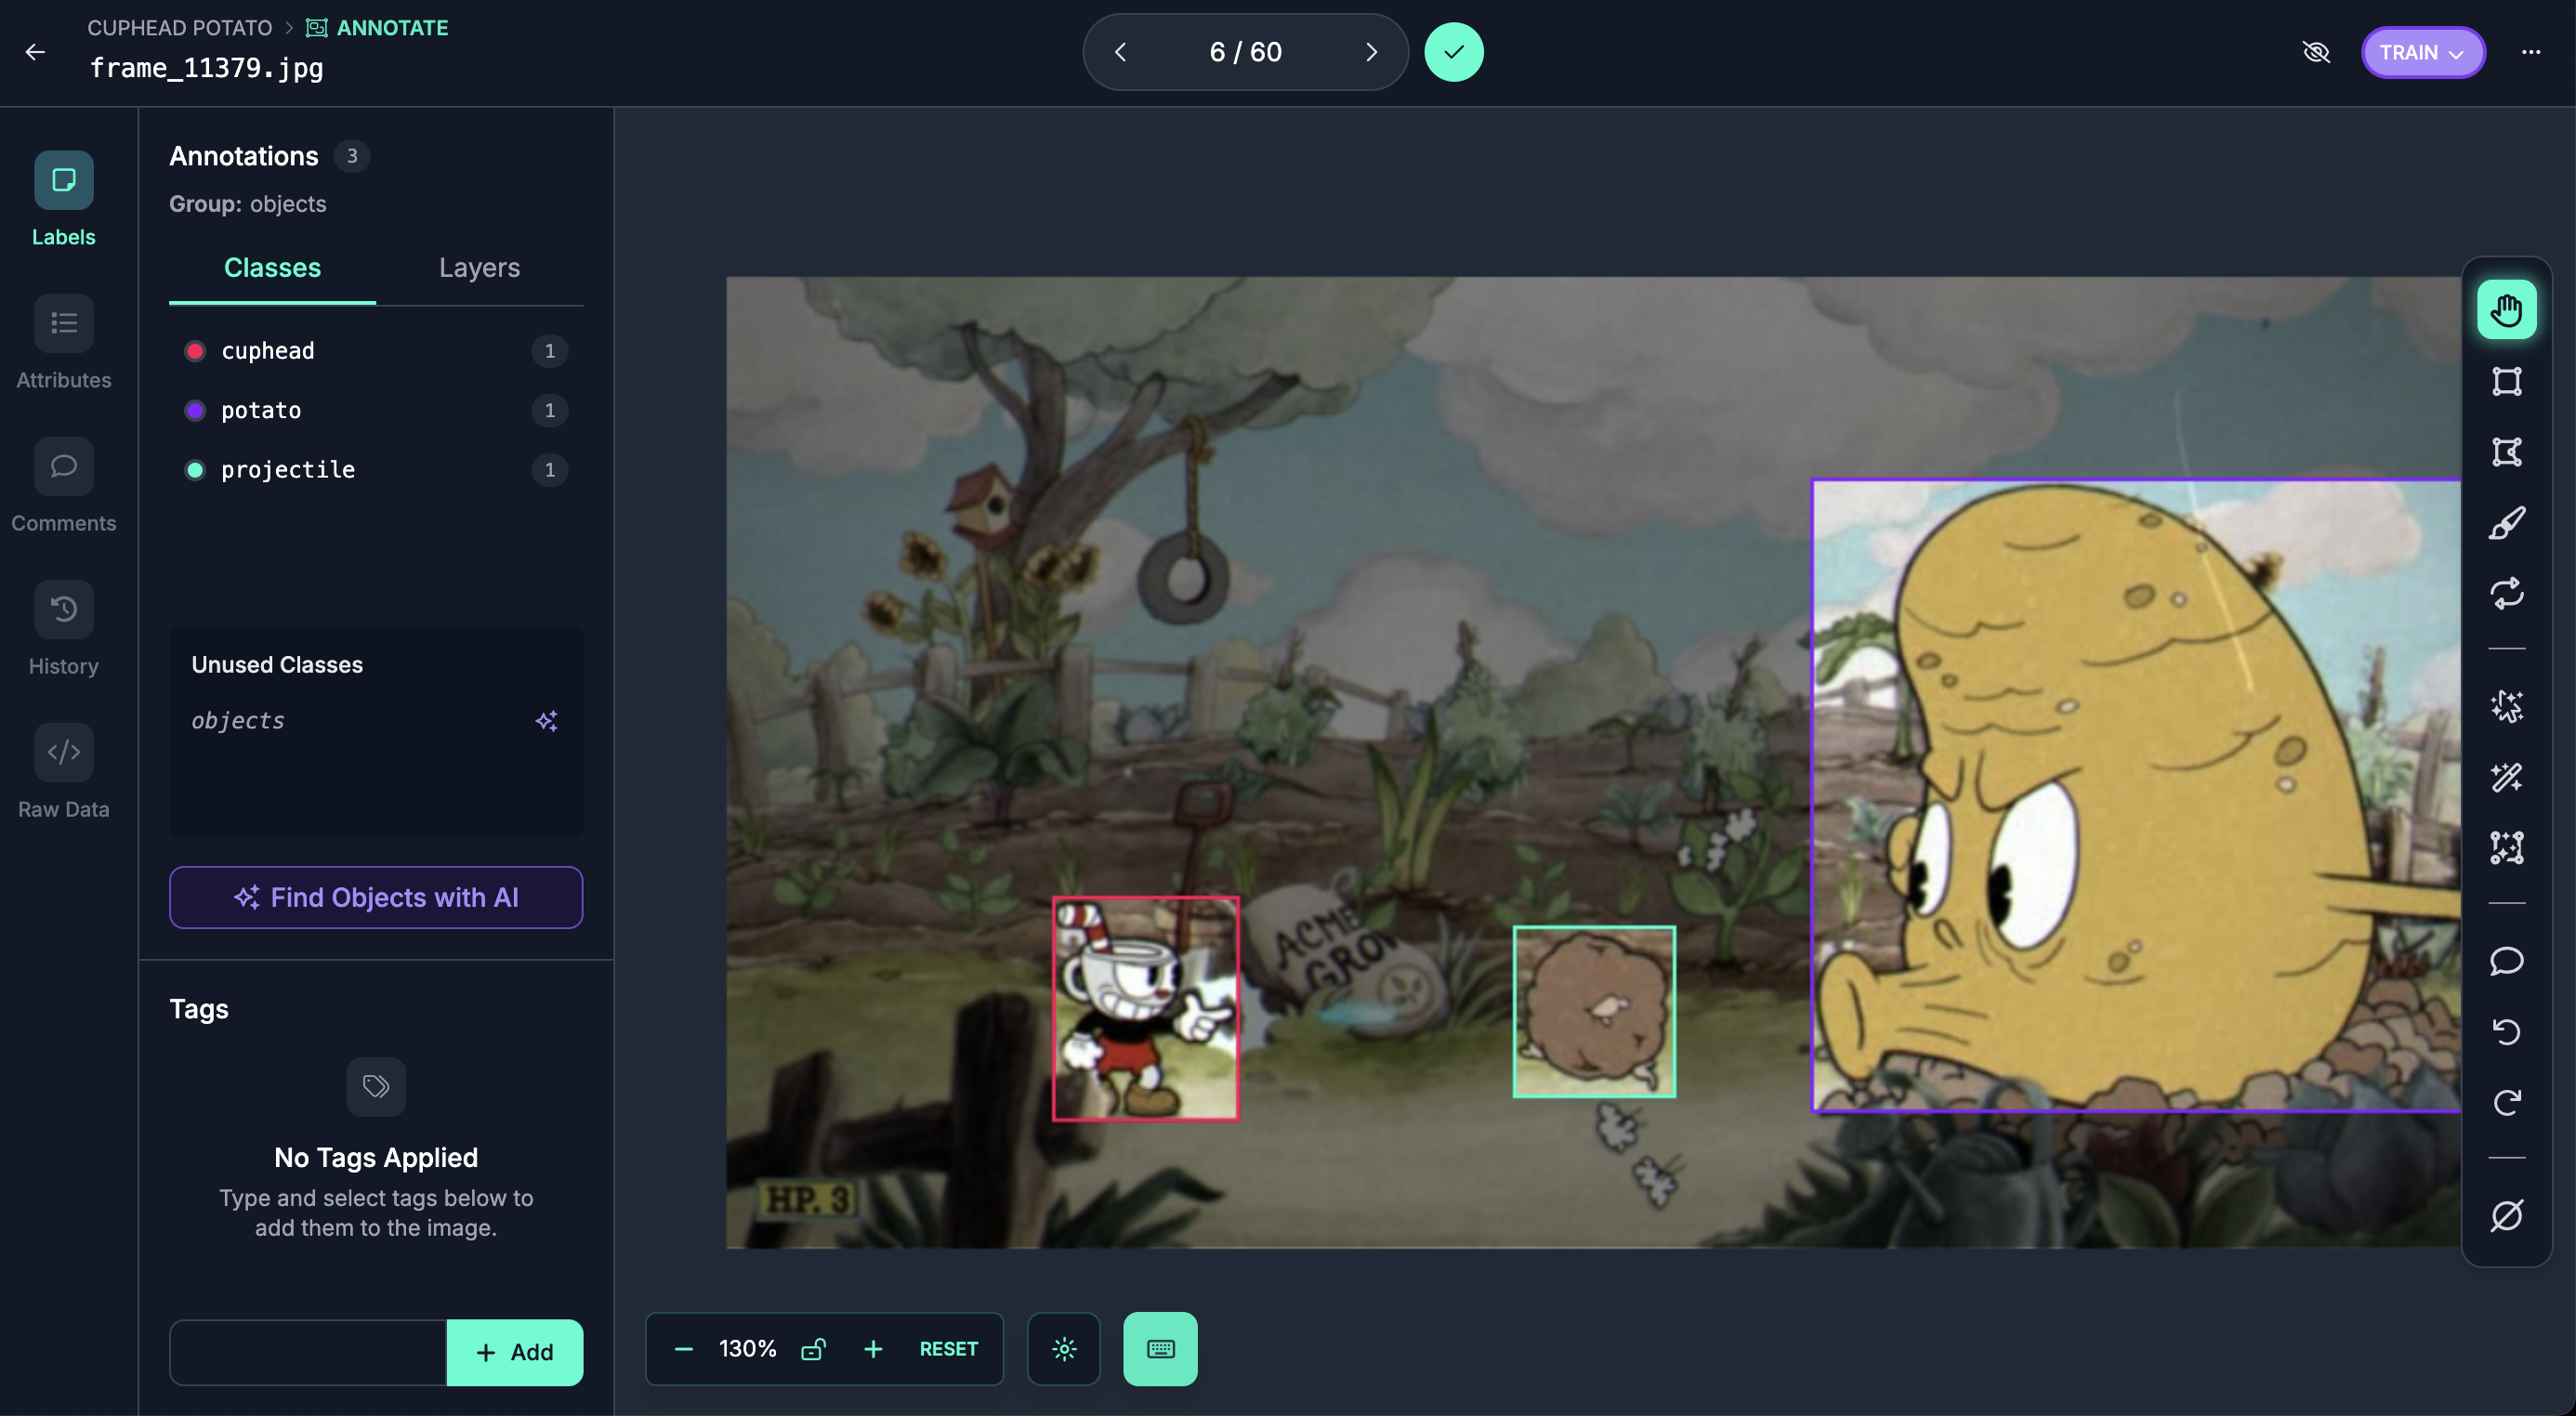
*Figure 1: Roboflow annotation*


#### **3.2.2 Vision Layer: YOLOv8 Optimization**
The objective is to map a raw frame $I \in \mathbb{R}^{1280 \times 720 \times 3}$ to a set of bounding boxes $B_t = \{b_1, b_2, \dots, b_n\}$. I utilized **YOLOv8n (Nano)**, a single-stage, anchor-free detector optimized for real-time inference.

To detect the "Projectile" class, the model minimizes a composite loss function:

$$ \mathcal{L}_{total} = \lambda_{box}\mathcal{L}_{box} + \lambda_{cls}\mathcal{L}_{cls} + \lambda_{dfl}\mathcal{L}_{dfl} $$

**1. Bounding Box Regression (CIoU Loss):**
Standard IoU (Intersection over Union) is insufficient for small objects, as slight misalignments result in zero overlap and vanishing gradients. I utilized **Complete IoU (CIoU)**, which incorporates geometric constraints:

$$ \mathcal{L}_{CIoU} = 1 - IoU + \frac{\rho^2(b, b^{gt})}{c^2} + \alpha v $$

*   $\rho(\cdot)$: Euclidean distance between the center points of the predicted box ($b$) and ground truth ($b^{gt}$).
*   $c$: Diagonal length of the smallest enclosing box.
*   **Significance:** This term penalizes Euclidean distance, forcing the model to converge the predicted box toward the projectile's center even when there is no pixel overlap, effectively solving the "small object" localization problem.

**2. Classification Threshold Optimization:**
A critical hyperparameter is the confidence threshold $\tau$. Let $\hat{p}_i$ be the confidence score of a detected object.
$$ \text{Detection} = \mathbb{I}(\hat{p}_i > \tau) $$

Standard implementations set $\tau = 0.25$. However, quantitative analysis (see Results) revealed that maximizing the **F1-Score** required solving for an optimal $\tau$ specific to this dataset:

$$ \tau_{opt} = \underset{\tau}{\text{argmax}} \left( 2 \cdot \frac{\text{Precision}(\tau) \cdot \text{Recall}(\tau)}{\text{Precision}(\tau) + \text{Recall}(\tau)} \right) \approx \mathbf{0.131} $$

By mathematically tuning this threshold, the system prioritizes **Recall** (Survival) over Precision, ensuring the agent detects faint, fast-moving projectiles that standard thresholds would suppress.

#### **3.2.3 Feature Engineering: The Physics Vector**
Instead of passing raw bounding box coordinates to the decision model, I engineered a **State Vector ($S_t$)** that explicitly represents the physics of the engagement relative to the player.

Given the center coordinates $(x_t, y_t)$ of Cuphead and the nearest Projectile at frame $t$:

1.  **Relative Euclidean Distance:**
    $$ \Delta x_t = |x_{proj} - x_{player}|, \quad \Delta y_t = |y_{proj} - y_{player}| $$
2.  **Closing Velocity (Finite Difference):**
    Since the vision model provides discrete snapshots, velocity is approximated using the first-order difference between consecutive frames:
    $$ v_x = \Delta x_t - \Delta x_{t-1} $$
    *   $v_x < 0$: The projectile is closing distance (Incoming Threat).
3.  **Player Vertical State:**
    $$ y_{player} $$
    *   To determine if the agent is already airborne

**The Final Normalized Input Vector:**
$$ S_t = \left[ \frac{\Delta x_t}{W}, \frac{\Delta y_t}{H}, \frac{v_x}{V_{max}}, \frac{y_{player}}{H} \right] $$

#### **3.2.4 Decision Layer: Weighted MLP**

The decision model approximates a function $f: S_t \to \{0, 1\}$ (Jump / No-Jump). Since temporal dynamics (velocity) are explicitly encoded in $S_t$, a Recurrent Neural Network is unnecessary. A standard Feed-Forward Multi-Layer Perceptron (MLP) is sufficient.

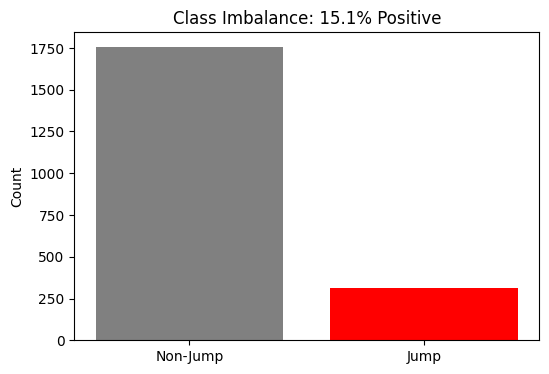

*Figure 2: Jump Class Imbalance Distribution.*

**Optimization via Weighted Binary Cross-Entropy:**
The dataset exhibits extreme class imbalance, with "Jump" actions occurring in only $\approx 15\%$ of frames. A standard loss function would converge to a trivial local minimum (always predicting "No Jump"). To counter this, I implemented **Class Weighting**:

$$ \mathcal{L}_{MLP} = - \frac{1}{N} \sum_{i=1}^{N} \left[ w_1 \cdot y_i \log(\hat{y}_i) + w_0 \cdot (1-y_i) \log(1-\hat{y}_i) \right] $$

Where the weights are inversely proportional to class frequency:
$$ w_1 = \frac{N_{total}}{2 \cdot N_{jump}}, \quad w_0 = \frac{N_{total}}{2 \cdot N_{no\_jump}} $$

This forces the optimizer to treat a False Negative (missed jump) as a high-cost error, biasing the agent towards a "survival-first" policy.


### **3.3 Implementation (Model Training)**

See **Appendix A** for full codebase

#### **3.3.1 Vision Training (YOLOv8)**
The YOLO model was fine-tuned using the `ultralytics` library.

In [ ]:
# Load pre-trained Nano model
model = YOLO("yolov8n.pt") 

# Fine-tune on Cuphead dataset
results = model.train(
    data="yolov8/data.yaml", 
    epochs=50, 
    imgsz=640, 
    batch=16,
    device=0, # Hardware acceleration (NVIDIA T4)
    project="runs/detect",
    name="cuphead_potato_model"
)

#### **3.3.2 Physics State Extraction**
The following logic converts the raw bounding boxes into the physics-based State Vector $S_t$. Note the normalization steps to ensure inputs remain between $[-1, 1]$:

In [ ]:
# 1. Identify Nearest Projectile (Euclidean Distance)
nearest = min(projectiles, key=lambda p: math.dist(p, cuphead_pos))

# 2. Calculate Relative Coordinates
dist_x = nearest[0] - cuphead_pos[0]
dist_y = nearest[1] - cuphead_pos[1]

# 3. Calculate Velocity (First-order difference from previous frame)
velocity = dist_x - prev_distance_x

# 4. Construct Normalized State Vector (Input to MLP)
state_vector = [
    dist_x / 1280.0,        # Normalized Distance X
    dist_y / 720.0,         # Normalized Distance Y
    velocity / 50.0,        # Normalized Closing Velocity
    cuphead_pos[1] / 720.0  # Normalized Player Height
]

#### **3.3.3 Decision Model (MLP)**
The MLP was implemented in TensorFlow/Keras. The input shape is set to `(4,)` to accommodate the four physics features derived above.

In [ ]:
model = keras.Sequential([
    layers.Input(shape=(4,)),             # Input: [Dist_X, Dist_Y, Vel, Height]
    layers.Dense(64, activation='relu'),  # Layer 1: Non-linear reasoning
    layers.Dropout(0.2),                  # Regularization
    layers.Dense(32, activation='relu'),  # Layer 2: Refinement
    layers.Dense(1, activation='sigmoid') # Output: Jump Probability
])

# Calculate Class Weights to handle imbalance (Jump is rare)
# w_1 = Total / (2 * Positives)
# Forces the model to prioritize Recall on the minority class
class_weights = {0: 0.55, 1: 3.54} 

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), 
          class_weight=class_weights, epochs=20)

### **3.4 Result & Evaluation**

#### 3.4.1 YOLO (Vision Model)

Quantitative analysis of the YOLOv8 performance reveals a significant disparity in feature detectability between class objects. As shown in **Table 1**, the model exhibits near-perfect detection for the 'Potato' class (Avg Confidence: 0.965), which is characterized by a large spatial footprint and distinct texture.

In contrast, the 'Cuphead' and 'Projectile' classes—which are essential for survival logic—yield significantly lower average confidence scores of **0.31** and **0.33** respectively.

| Class Name | Avg Confidence |
| :--- | :--- |
| **Potato** | **0.9655** |
| Cuphead | 0.3100 |
| **Projectile** | **0.3327** |


*Table 1: YOLOv8 Detection Metrics (code in Appendix A)*

This disparity necessitates a deviation from standard YOLO implementation. While default confidence thresholds are typically set to 0.25 or 0.40, our **F1-Confidence Curve analysis (Figure 3)** indicates that the optimal trade-off between precision and recall for this dataset occurs at a threshold of **0.131**.

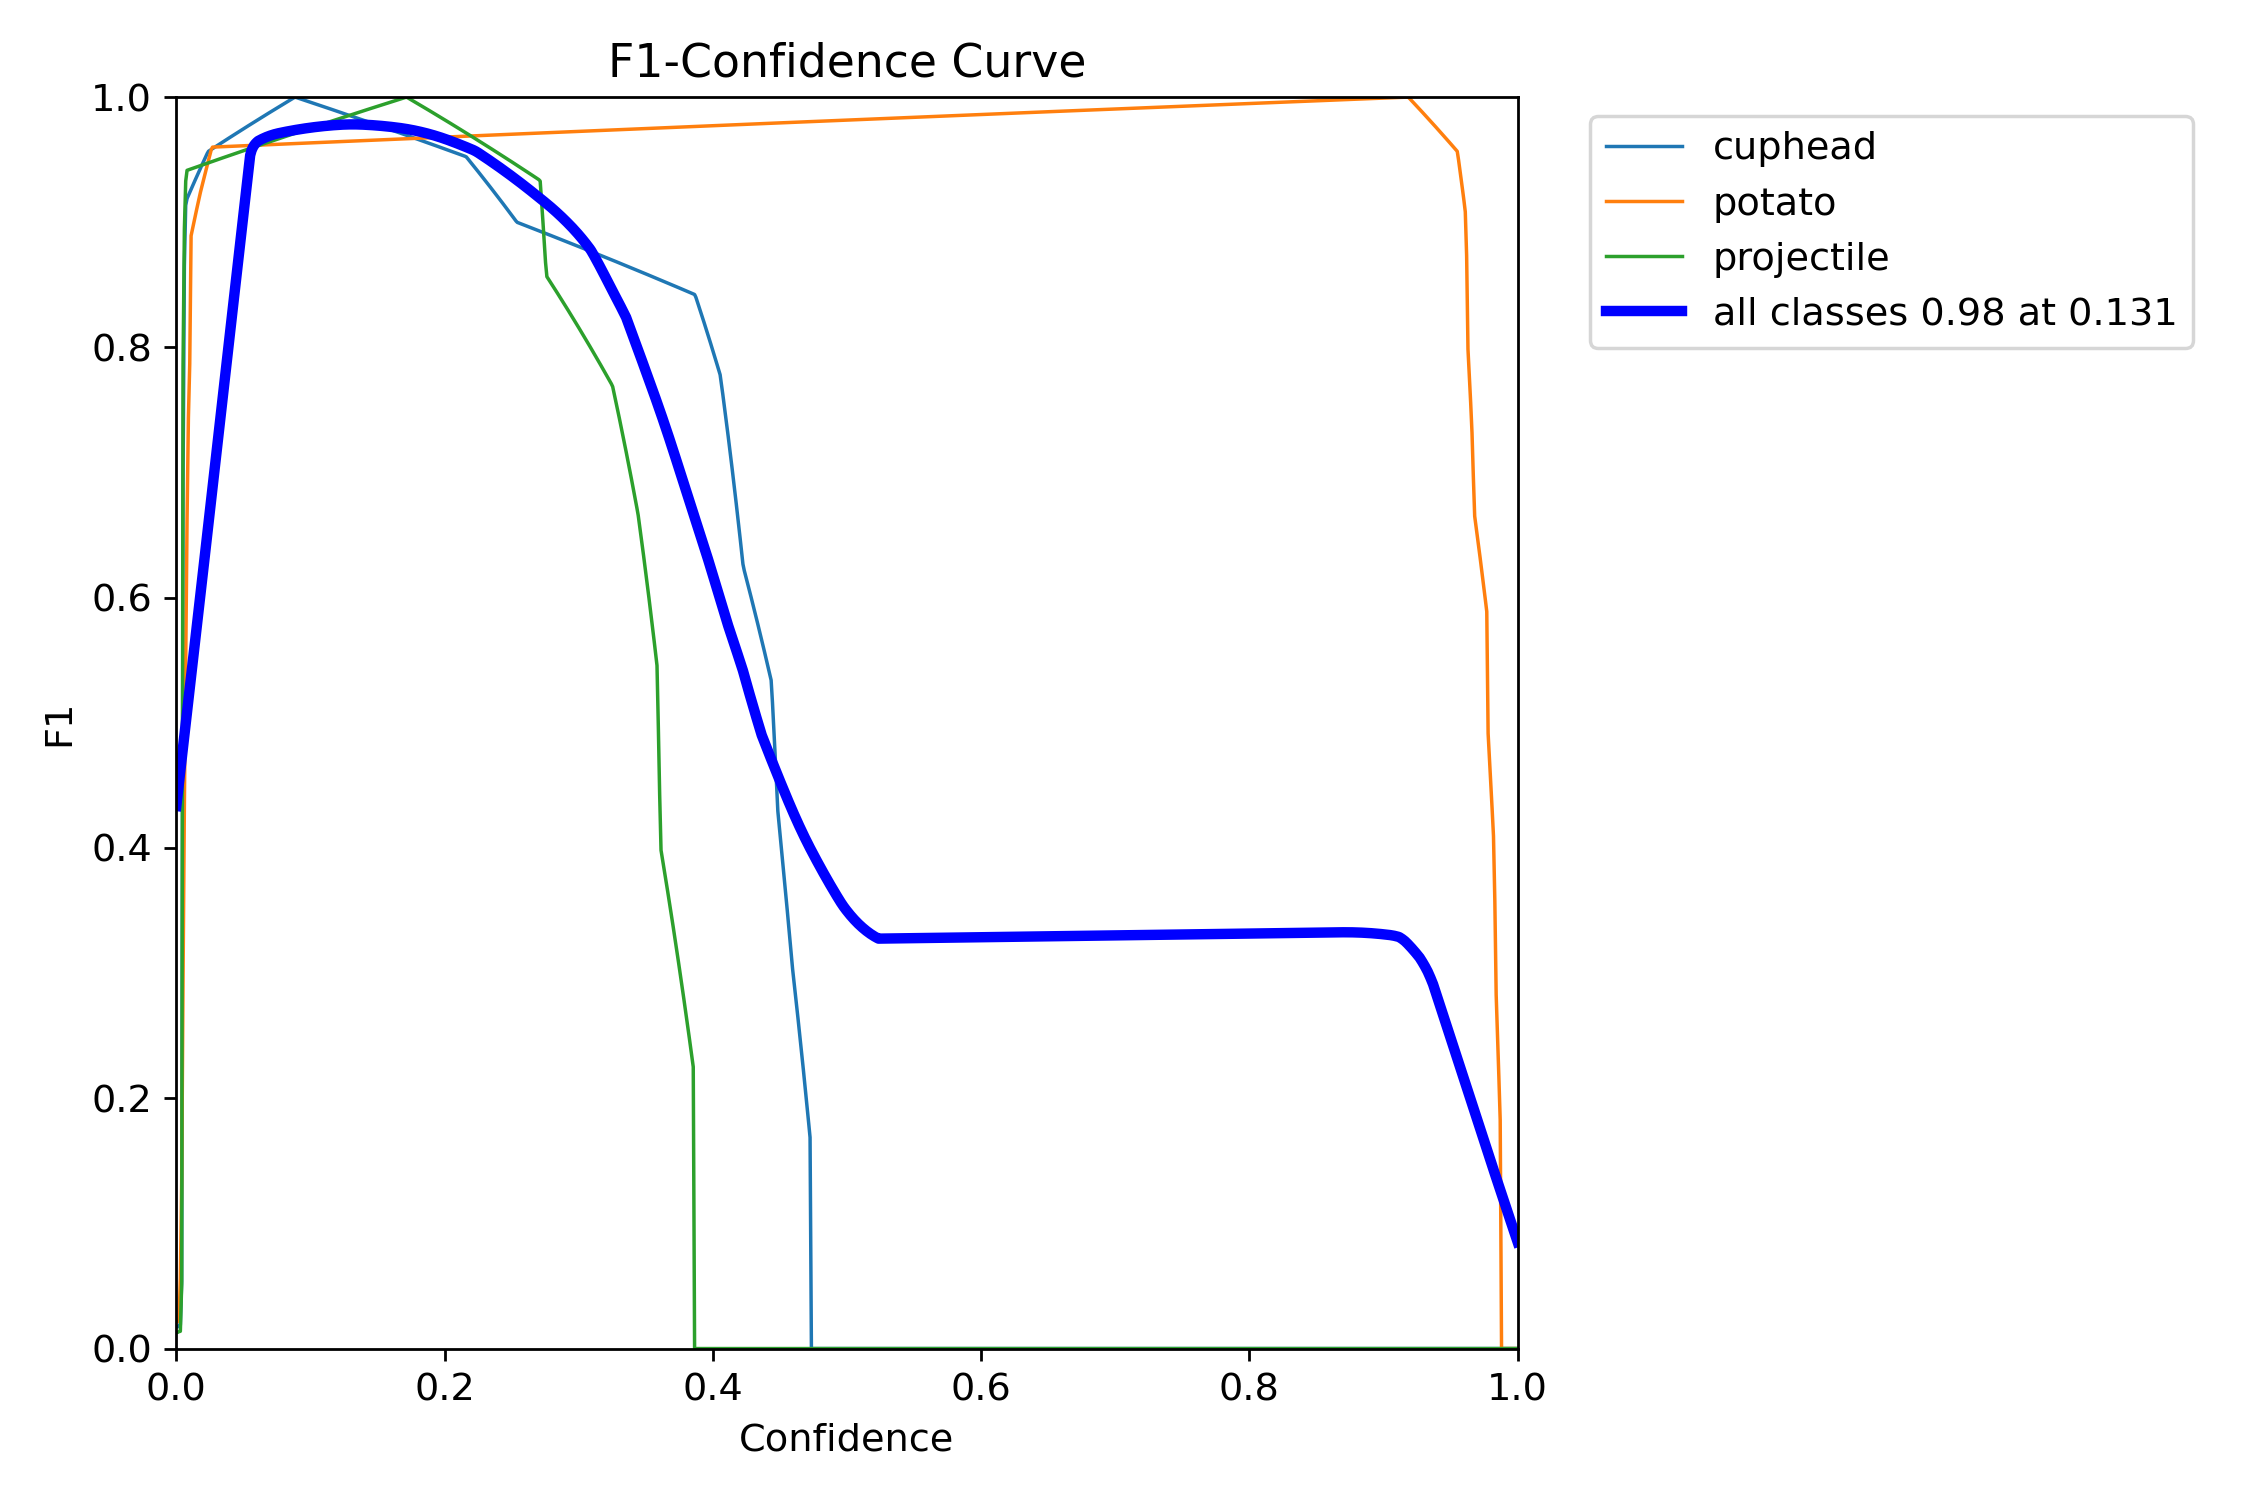
*Figure 3: F1-Confidence Curve analysis*

At a threshold of 0.4, the model has detection rate near zero for projectiles. By lowering the threshold to 0.1, it recovers the projectile detections required for the physics engine, albeit with a slight increase in bounding box jitter.

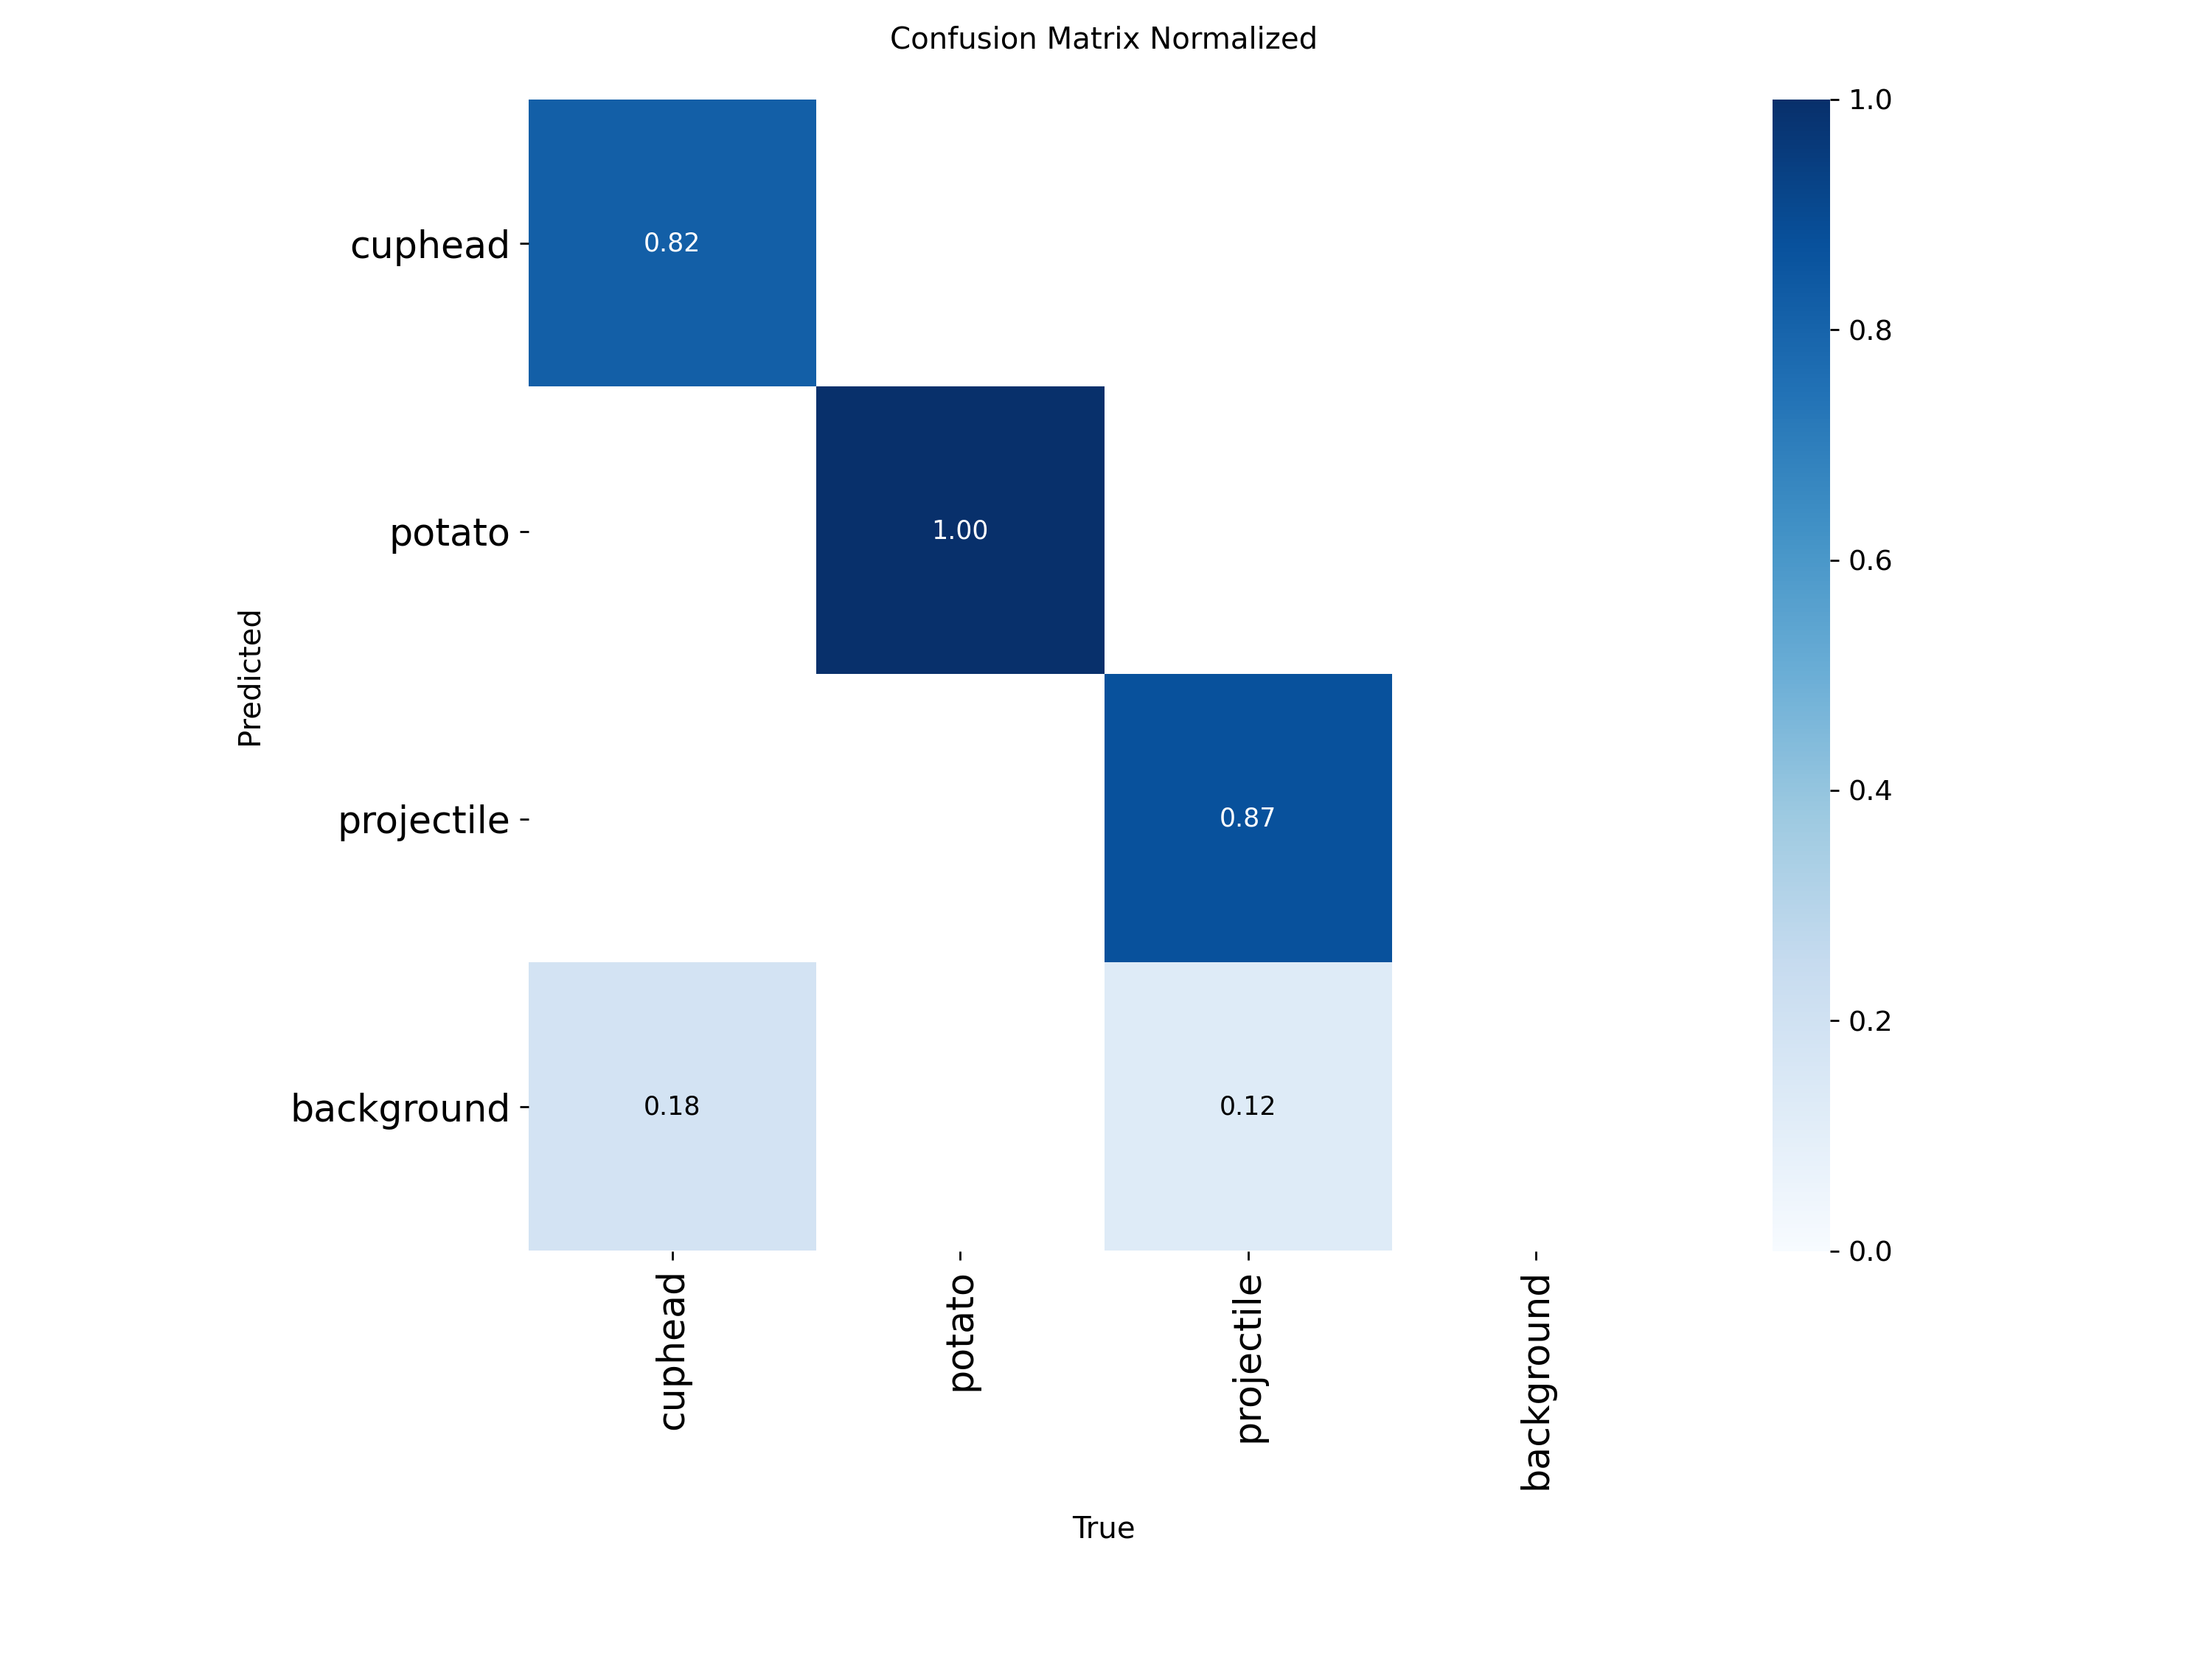
*Figure 4: YOLO Normalized Confusion Matrix*

The Normalized Confusion Matrix (**Figure 4**) confirms that the model's primary failure mode is not misclassification (e.g., confusing Cuphead for a Potato), but rather **False Negatives**. Approximately 12% of projectile instances are misclassified as "Background," primarily due to motion blur and the object's color.

#### **3.4.2 MLP (Decision Model)**
The MLP decision model, trained on the state vector $S_t = [\Delta x, \Delta y, v_x]$, successfully learned a non-linear decision boundary for the "Jump" action.

![MLP Decision Boundary Heatmap](images/MLP%20Decision%20Boundary%20Heatmap.png)

*Figure 5: MLP Decision Boundary Heatmap*

Figure 5 visualizes the model's learned logic. The red region (High Jump Probability) corresponds to states where the projectile is both **close** (Distance < 200px) and **approaching fast** (high velocity has higher jump probability). The gradient transition from green (Idle) to red (Jump) demonstrates that the model is not acting randomly, but has approximated the underlying physics of a collision.

#### **Threshold Tuning (F-Beta Optimization)**
A standard classification threshold of $0.5$ proved suboptimal for real-time gameplay. While it captured most necessary jumps, it suffered from "panic jumping"—triggering actions when the projectile was safe, which destabilizes the agent. To refine this behavior, I implemented a dynamic threshold tuning algorithm based on the **F-Beta Score**.

**Rationale for F0.8:**
I specifically optimized for the **F0.8-score** (where $\beta=0.8$).
*   **The Problem:** An F1 score treats False Positives (jumping when unnecessary) and False Negatives (failing to jump) equally.
*   **The Solution:** By setting $\beta < 1$, the metric assigns more weight to **Precision**. This enforces a preference for high confidence to ensure stability, preventing the agent from spamming inputs, while maintaining enough sensitivity to react to fast-moving projectiles.

The optimization process yielded a significantly higher decision threshold of **0.784**.

#### **Analysis of Optimization Curve**
Figure 6 illustrates the relationship between the decision threshold and the F0.8 score.

![MLP Optimization Curve](images/MLP%20optimization%20curve.png)

*Figure 6: F0.8 Score Optimization Curve. The red dashed line indicates the optimal threshold.*

As the threshold increases, the model becomes more conservative. Usefully, the curve shows a distinct peak around 0.78.
*   **Low Threshold (< 0.5):** The model jumps too often (High Recall, Low Precision), leading to a lower F0.8 score.
*   **Optimal Threshold (0.784):** This sweet spot maximizes the F0.8 metric, balancing the need to jump for survival with the need to stay grounded for stability.
*   **High Threshold (> 0.85):** The model misses too many generic jumps, causing the score to drop rapidly.

## 5. Pipeline B: Autoencoder + GRU

### **5.1 Concept**
1.  **Dimensionality Reduction (Autoencoder(AE)):** A semi-supervised network that compresses high-dimensional raw pixel data into a dense, low-dimensional "latent representation" ($z$).
2.  **Sequence Modeling (Gated Recurrent Unit (GRU)):** A recurrent neural network that learns temporal dynamics and creates a control policy by predicting actions based on the history of these latent states.

**Scientific Rationale:**
While Pipeline A relies on explicit feature engineering (defining "what" a projectile is), Pipeline B adopts an implicit perception approach. The hypothesis is that the optimal strategy for Cuphead relies not just on object position, but on "game flow"—the rhythmic patterns of animations and background cues. By removing the bottleneck of human-defined classes (bounding boxes), I allowed the model to learn its own feature representation directly from the manifold of gameplay pixels. This mimics human intuition: "seeing" the game as a continuous stream of visual context rather than a list of coordinates.

*(Note: Mathematical Upbrininging is skipped since overlaps with previous assingment)*


### **5.2 Implementation**

See **Appendix B** for the full source code.

#### **5.2.1 Data Preparation and Sequence Windowing**
Unlike Pipeline A, which processed discrete snapshots, Pipeline B requires temporal context. The raw video frames were downsampled significantly to **$128 \times 72$ (Grayscale)** to reduce the computational load on the Autoencoder.

The data was then restructured into sliding windows to satisfy the input requirements of the Recurrent Neural Network. A sequence length of $T=10$ frames was chosen to capture the velocity of the projectile.

In [ ]:
# Create Sliding Windows (Context = 10 frames)
def create_sequences(features, labels, seq_len=10):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(features)):
        X_seq.append(features[i-seq_len:i]) # Shape: (10, 512)
        y_seq.append(labels[i])             # Shape: (1)
    return np.array(X_seq), np.array(y_seq)


#### **5.2.2 Latent Feature Extraction (Autoencoder)**
I utilized a deep Convolutional Autoencoder to compress the $128 \times 72$ frames into a latent vector $z \in \mathbb{R}^{512}$. The architecture uses three convolutional blocks with increasing filter sizes (32, 64, 128) to capture hierarchical features, followed by a dense bottleneck.

In [ ]:
# Encoder Architecture
inp = layers.Input(shape=(72, 128, 1))
x = layers.Conv2D(32, 3, padding='same', activation='relu')(inp)
x = layers.MaxPool2D(2, padding='same')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D(2, padding='same')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D(2, padding='same')(x)
flat = layers.Flatten()(x)
z = layers.Dense(512, activation='relu', name='latent')(flat)

# Model compilation
ae = models.Model(inp, out)
ae.compile(optimizer='adam', loss='mse')

*Note: The model was retrained specifically on the "Potato Phase" segments to ensure the reconstruction loss minimized artifacts specific to the boss's dirt-clod projectiles.*

#### **5.2.3 Sequence Modeling (GRU) with Focal Loss**
The decision model is a Gated Recurrent Unit (GRU) that ingests the sequence of latent vectors. To address the severe class imbalance (Jumps are rare), I implemented **Sigmoid Focal Loss** rather than standard Binary Cross-Entropy. Focal Loss down-weights easy negatives (background frames), forcing the model to focus on the hard positives (jumps).

$$ FL(p_t) = -\alpha_t (1 - p_t)^\gamma \log(p_t) $$

Where $\gamma=2.0$ acts as the focusing parameter.

In [ ]:

# Focal Loss Definition
def sigmoid_focal_loss(gamma=2.0, alpha=0.25):
    def loss_fn(y_true, y_pred):
        p_t = tf.where(tf.equal(y_true, 1.0), y_pred, 1 - y_pred)
        loss = -alpha * tf.pow(1.0 - p_t, gamma) * tf.math.log(p_t)
        return tf.reduce_mean(loss)
    return loss_fn

# GRU Architecture
inp = layers.Input(shape=(10, 512)) # (Sequence_Length, Latent_Dim)
x = layers.GRU(128, return_sequences=True)(inp)
x = layers.Dropout(0.3)(x)          # Regularization
x = layers.GRU(64)(x)
out = layers.Dense(1, activation='sigmoid')(x)

gru_model.compile(optimizer='adam', loss=sigmoid_focal_loss(), metrics=['accuracy'])

## **5.3 Results & Evaluation**

### **5.3.1 Vision Layer: Latent Reconstruction Analysis**
Unlike Pipeline A, which relies on discrete object detection, Pipeline B relies on the Autoencoder’s ability to compress the entire visual scene into a semantic bottleneck ($z \in \mathbb{R}^{512}$). To validate this, I inspected the reconstruction quality of the decoder.

**Figure 7** displays the input frames (Top) versus the Autoencoder’s reconstruction (Bottom).

![AE reconstruction.png](<attachment:AE reconstruction.png>)

*Figure 7: Comparison of Original Gameplay (Top) and AE Reconstruction (Bottom).*

**Observation:**
The reconstruction successfully captures the **global structure** of the scene: the position of Cuphead, the boss (Potato), and the horizon line are preserved. However, the projectiles, which are critical for survival, often appear blurred or "ghostly" in the reconstructed frames.
*   **Implication:** This explains the lower precision observed later in the decision model. Because the latent representation smears small, fast-moving objects into the background texture, the GRU cannot rely on precise coordinates. Instead, it must infer threats based on larger changes in the scene's manifold (e.g., the boss’s attack animation cycles).

### **5.3.2 Decision Layer: Threshold Optimization**
The GRU outputs a continuous probability score $P(Jump_t | z_{t-10}...z_t)$. As with Pipeline A, a standard decision threshold of $0.5$ is not necessarily optimal. I performed an exhaustive search on the **Training Set** to maximize the **F0.8-Score** (prioritizing Precision).

![Threshold Optimization Curve.png](<attachment:Threshold Optimization Curve.png>)

*Figure 8: Precision-Recall-Fbeta Curve. The vertical dotted line indicates the optimal threshold.*

**Optimization Results:**
*   **Optimal Threshold:** **0.3607**
*   **Max F0.8 Score:** 0.9805

**Analysis:**
Interestingly, the optimal threshold for Pipeline B (0.361) is significantly lower than Pipeline A (0.898).
*   *Pipeline A* was confident but noisy, requiring a high bar to filter out false positives.
*   *Pipeline B* is **conservative in its probability estimates**. Because the Autoencoder introduces input noise (blur), the GRU rarely predicts a "Jump" with near-1.0 confidence. To capture the necessary jumps (Recall), the threshold had to be lowered. The curve in **Figure 9** shows that Recall (Green) drops precipitously after $t=0.4$, forcing the optimization to settle near $0.36$.
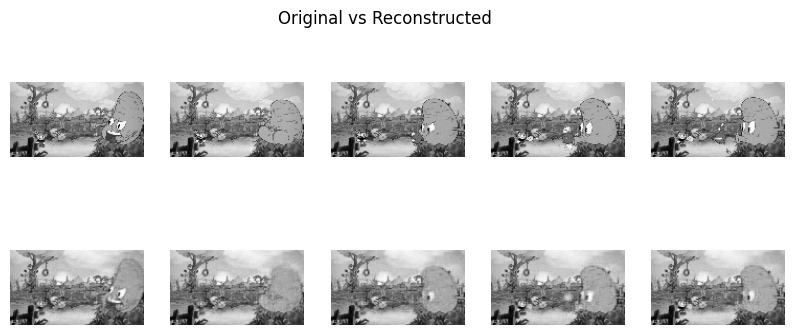
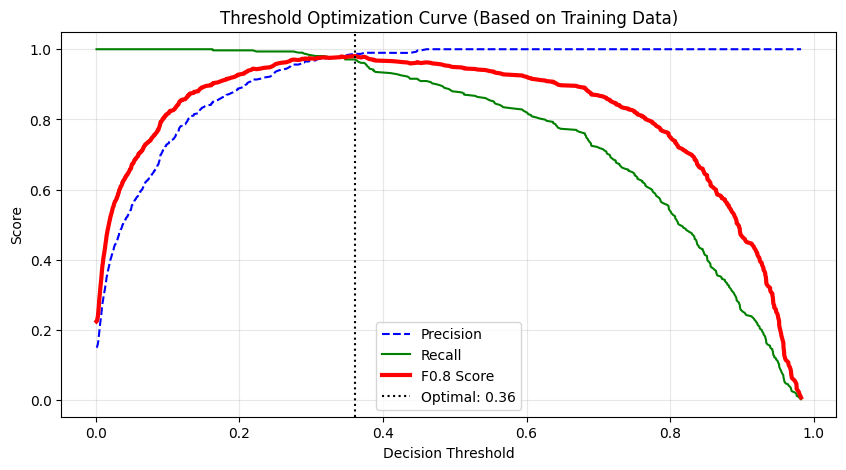

## **6. Synthesis & Comparative Analysis**

### **6.1 Training Set Dynamics: Robustness vs. Overfitting**

To understand the fundamental difference in how the two architectures "think," I analyzed their behavior across the 15 training sessions. While both models achieved high accuracy, their behavior during human error scenarios (specifically Session 9) reveals the distinction between *learning a rule* and *memorizing a sequence*.

#### **6.1.1 YOLO + MLP**
The YOLO+MLP architecture demonstrated that it successfully decoupled the **action** from the **imitator**.

![MLP train timeline.png](<attachment:MLP train timeline.png>)
*Figure 9: Pipeline A Training Timeline.*

*   **Behavior:** As shown in **Figure 9**, especially session 10, the model synchronizes perfectly with the human during a clean run.

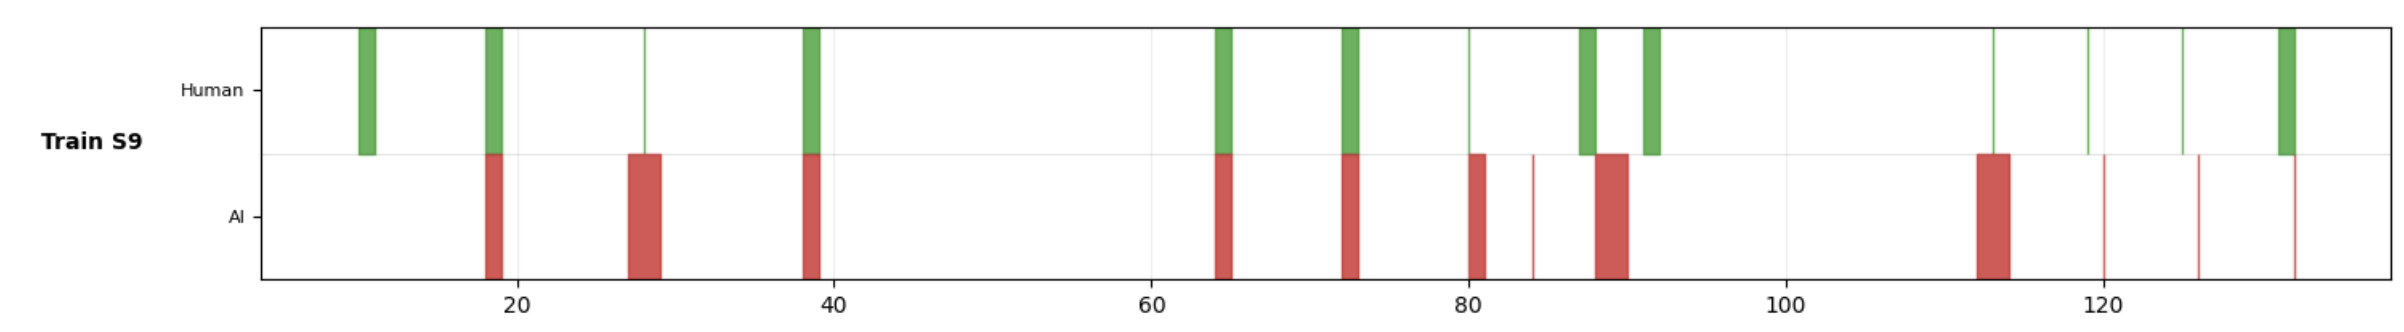
*Figure 10: Pipeline A Robustness in Session 9.*
*   **The Stress Test (Session 9):** The critical insight arises in Session 9, where the human player failed to jump and collided with the projectile.
    *   *Observation:* Despite the human input was "panicking" and ceasing for a few frames (due to the character being stunned), the AI (Red) **continued to output "Jump" commands.**
    *   *Implication:* This confirms the model is **robust**. It does not care what the human is doing; it calculates that $Distance < Threshold$ and $Velocity > 0$, triggering the jump. It has learned the underlying physics of survival ($Action = f(State)$), effectively "correcting" the human's mistake.
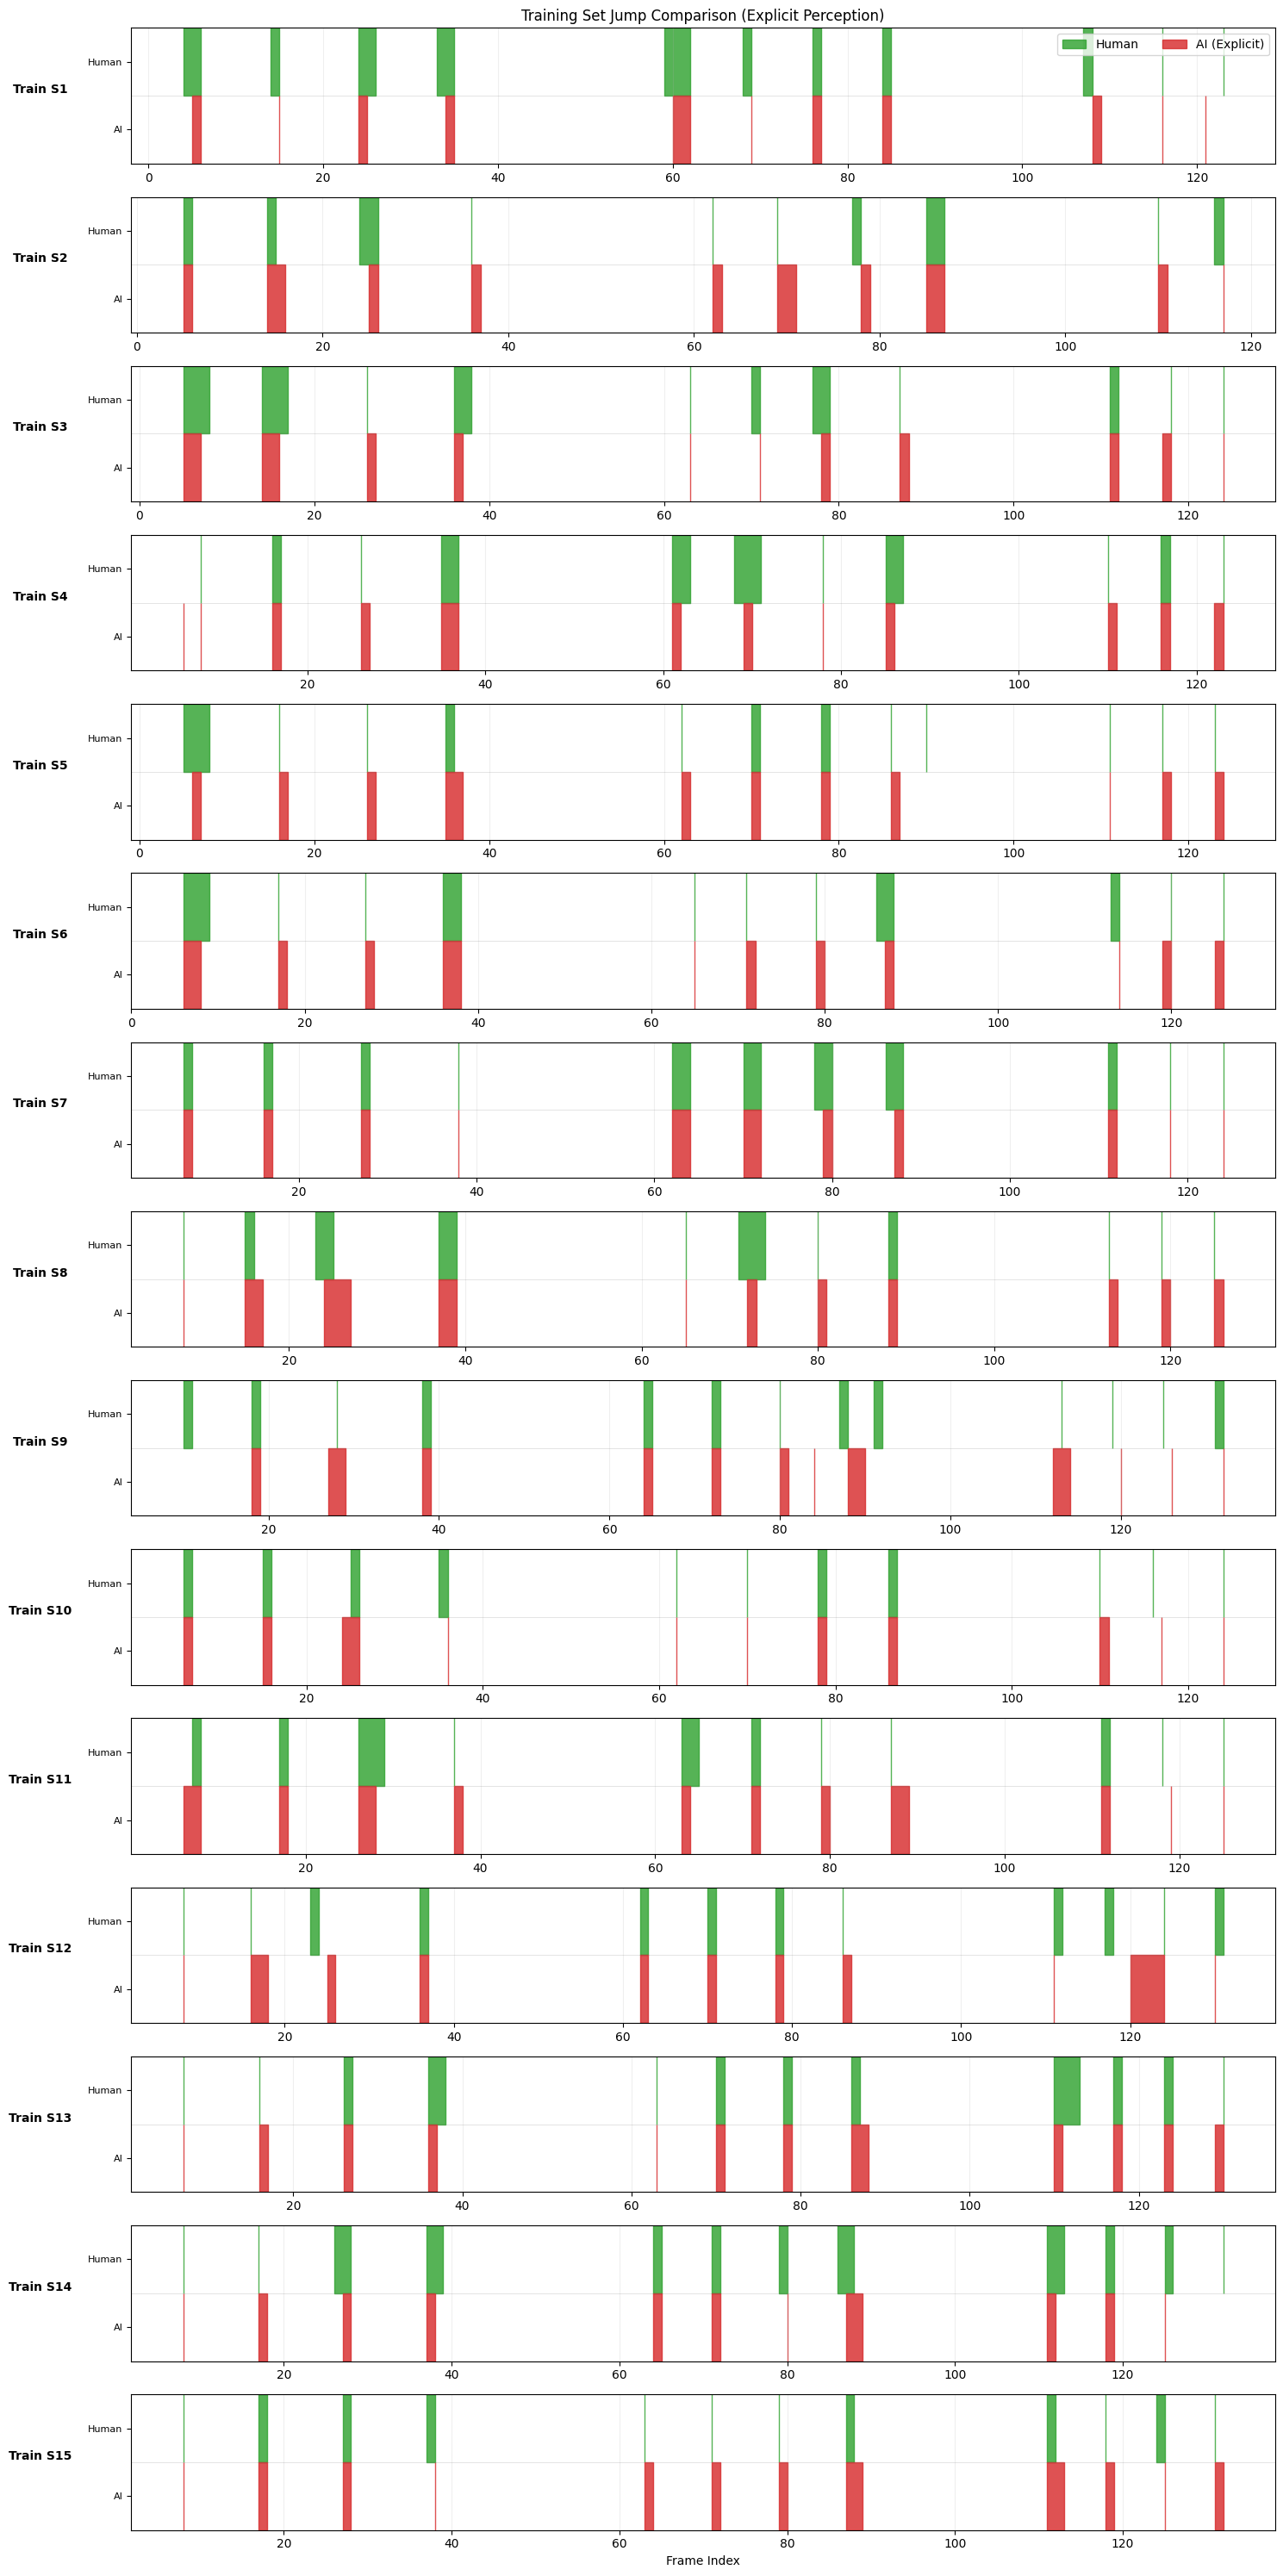


#### **6.1.2 AE + GRU**
The AE+GRU architecture aligned better with human input, but this came at the cost of generalization.

![Training Set Timeline.png](<attachment:Training Set Timeline.png>)

*Figure 11: Pipeline B Training Timeline.*

*   **Behavior:** The GRU better aligns with human input compared to MLP (see **Figure 11**), creating a stable policy during successful runs (e.g., Session 3).
*   **The Overfitting Evidence (Session 9):** In the same failed run where Pipeline A showed robustness, Pipeline B failed.
    *   *Observation:* When the human player collided with the boss and stopped inputting commands, **the AI also stopped jumping.** The purple bars in Session 9 disappear exactly when the green bars do.
    *   *Implication:* This indicates **Overfitting**. The GRU did not learn "Jump to avoid projectile"; it learned "At this specific point in the sequence, the expert did nothing, so I will do nothing." The model memorized the specific visual signature of the failure state (or the specific timestamp) rather than the general rule of evasion ($Action = f(Sequence/Time)$).

While Pipeline B produces more human-input-aligned timelines, Pipeline A proves to be the superior agent for autonomy because it disentangles the *optimal action* from the *demonstrator's performance*.
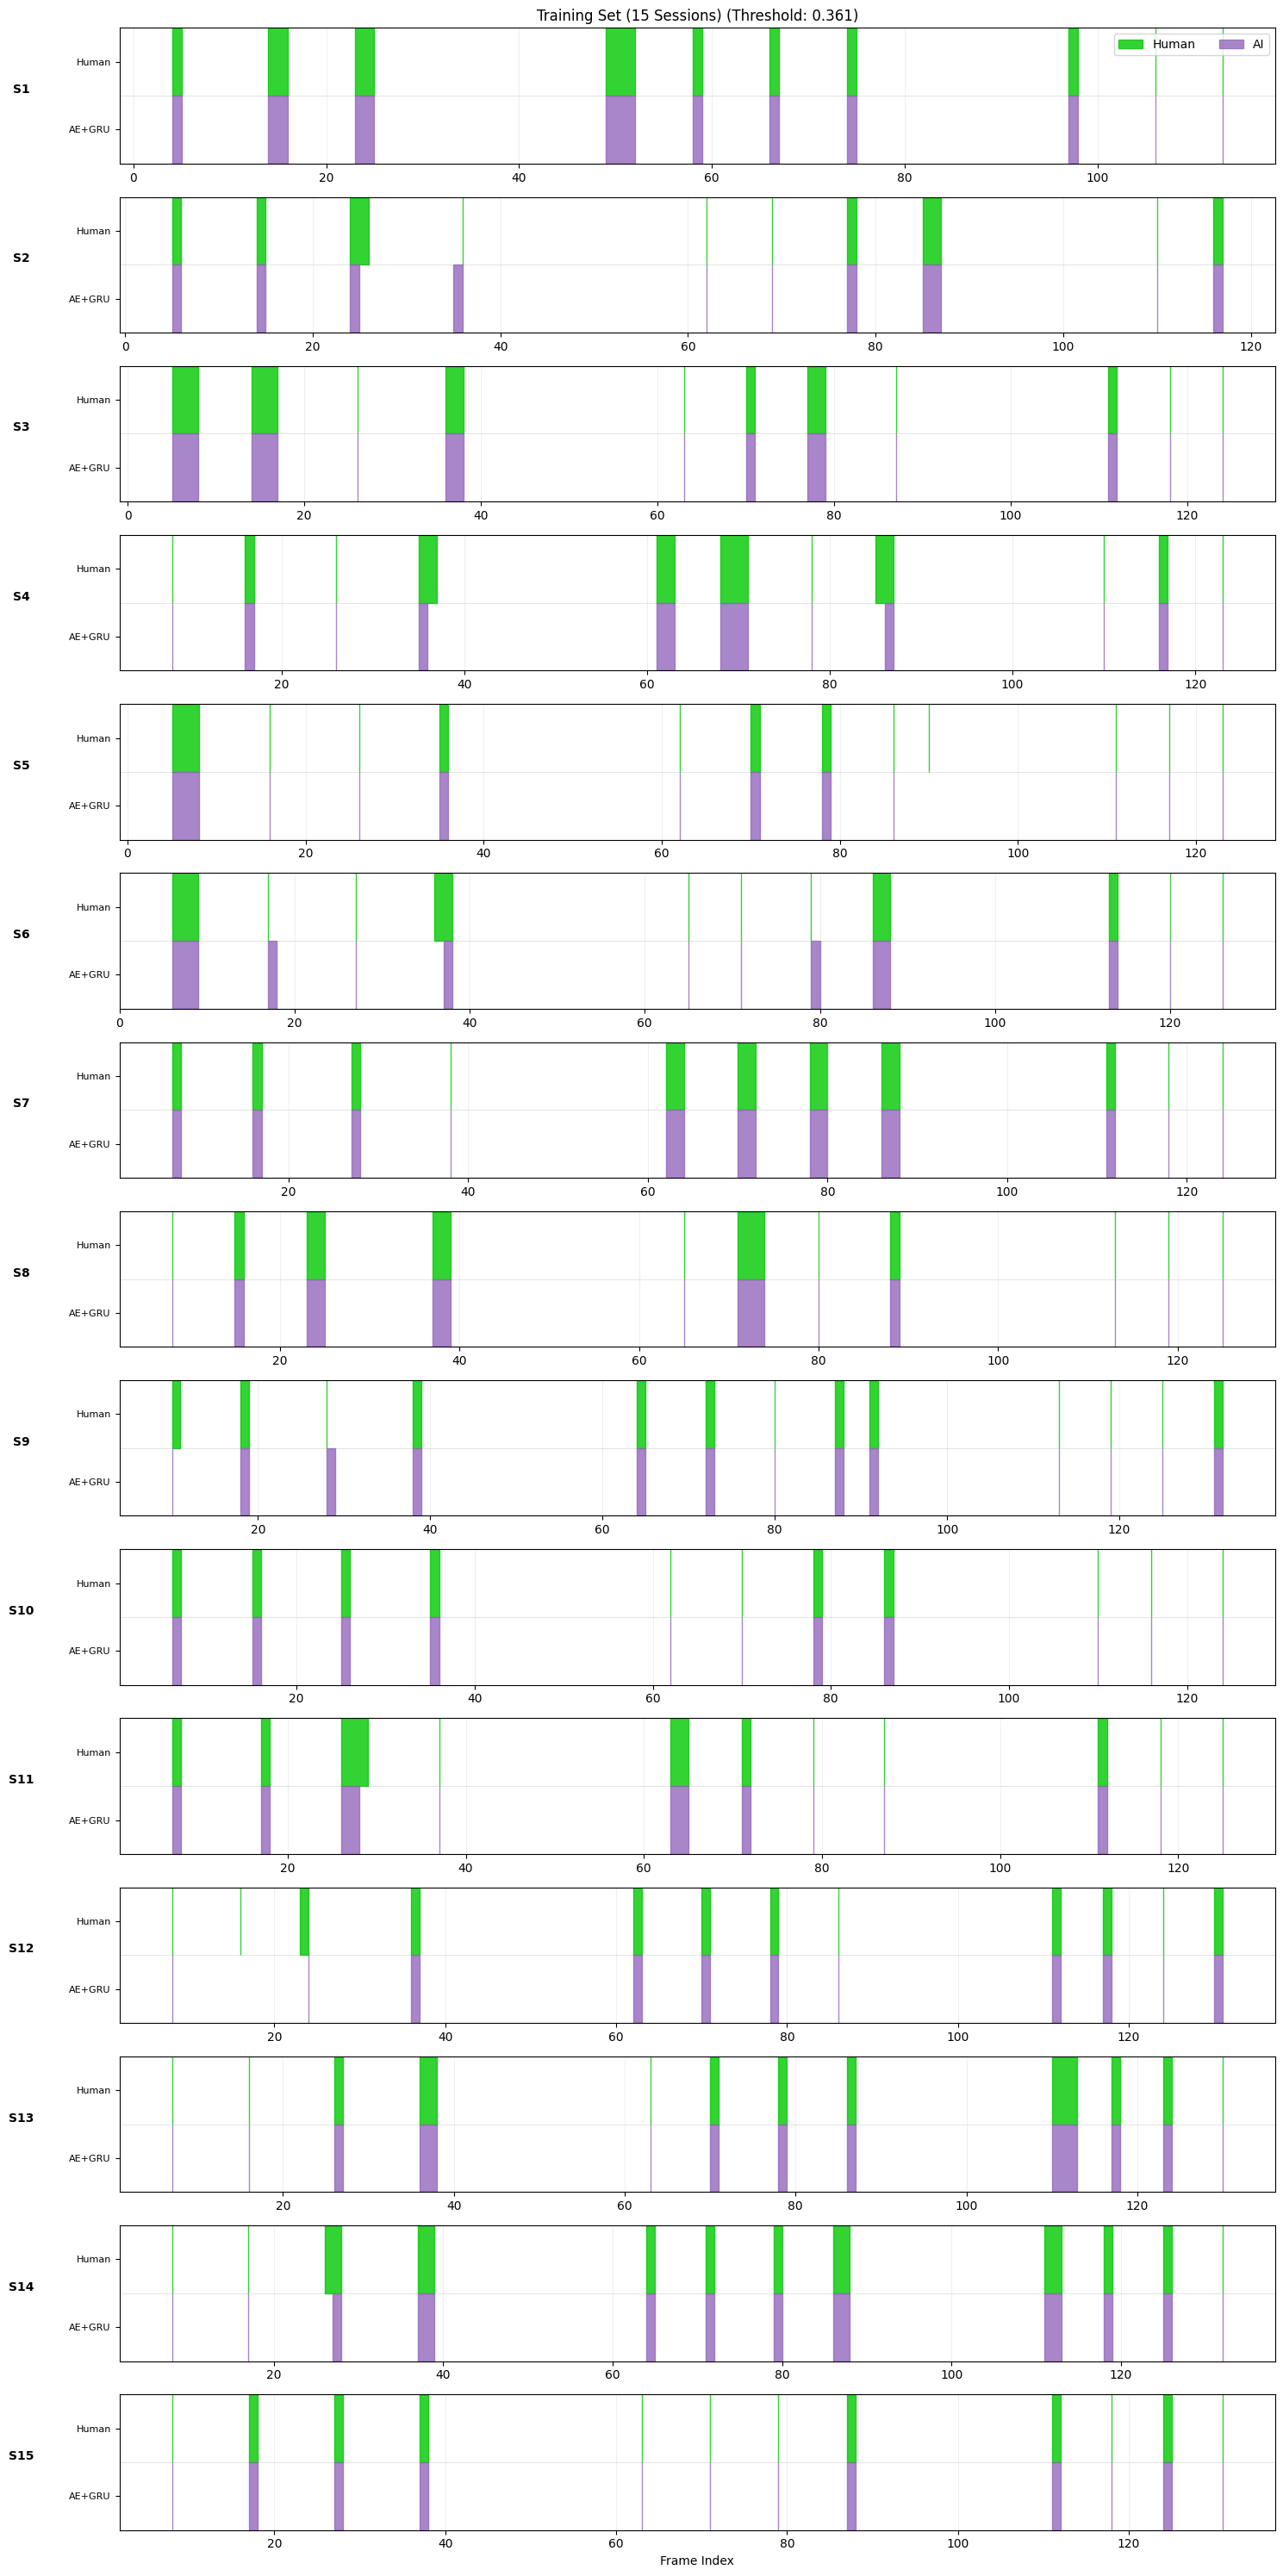

### **6.2 Test Set Evaluation Comparison**

To verify that the models generalize to unseen data, I evaluated both architectures on the hold-out Test Set. While the training metrics favored Pipeline A, the test timelines reveal critical behavioral differences that raw numbers obscure.

#### **6.2.1 Pipeline A (YOLO + MLP)**

![MLP test timeline.png](<attachment:MLP test timeline.png>)
*Figure 13: Pipeline A Test Timeline. Note the anomaly around frame 58.*

**Analysis:**
*   The model achieved a high **Recall of 0.88**, successfully identifying the majority of threats. The **Precision (0.70)** indicates a generally clean signal, filtering out most background noise.
*   Despite the strong statistics, the timeline reveals a critical flaw around **Frame 58**. The AI (Red) triggers a short, isolated jump where the Human (Green) remains idle.
    *   *Cause:* This is likely a single-frame detection error where the YOLO model momentarily miscalculated a projectile's velocity or position, causing the physics engine to return a "True" collision state.
    *   *Risk:* In a platformer like *Cuphead*, an unforced jump is dangerous. It locks the player into a fixed trajectory, potentially landing them directly into an incoming projectile.

#### **6.2.2 Pipeline B (AE + GRU)**

![GRU test timeline.png](<attachment:GRU test timeline.png>)
*Figure 14: Pipeline B Test Timeline. Note the broader, less precise coverage.*

**Analysis:**
*   Pipeline B suffered from low **Precision (0.55)**, indicating it predicted "Jump" nearly twice as often as necessary. However, its **Recall (0.86)** remained competitive with Pipeline A.
*   The timeline shows that Pipeline B's errors are fundamentally different. It does not exhibit random  spikes. Instead, it creates **broad, continuous zones of caution**. The Purple bars (AI) often start earlier and end later than the Green bars (Human).

    *   *Interpretation:* While statistically "worse" (more False Positives), this behavior presents a specific risk. Unlike shooting, where continuous input is safe, jumping is a committed action. Holding the button longer merely extends the jump or does nothing, but the **early onset** of these broad zones is dangerous, as jumping too early can cause the player to land directly on the incoming projectile.

#### **6.2.3 Summary**
This comparative analysis highlights the limitations of standard classification metrics (F1-Score) for gameplay agents.

1.  **Pipeline A** has higher accuracy (0.94 vs 0.91), but its errors are discrete and potentially fatal.
2.  **Pipeline B** has lower precision, and its tendency to create broad activation zones risks **early jumps**, which can be fatal if the player lands before the projectile passes.

Statistics alone cannot determine which agent survives longer. A high-accuracy model might die instantly if its 6% error rate occurs at a critical moment. **Therefore, to determine which model is the superior player, I moved beyond static datasets and actually let them play the game.**
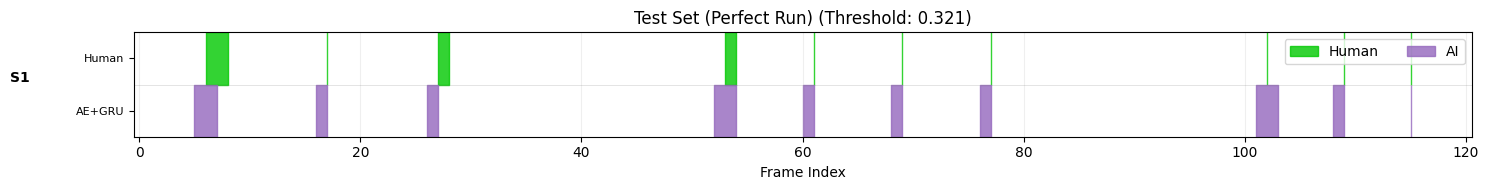
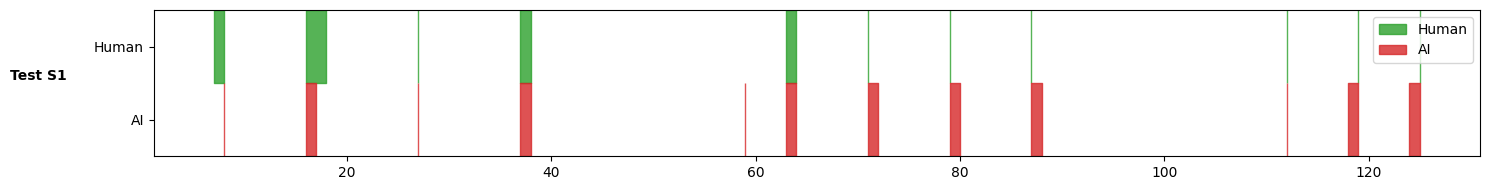

# appendix


 ### 1. Custom Segmentation Tooling
Standard video editing tools were insufficient because I needed to preserve the exact millisecond alignment between video frames and the asynchronous keystroke logs (UTC timestamps).

To solve this, I developed a custom Python utility, `mark_potato_segments.py`, which utilizes OpenCV and the original `_frames.jsonl` log file.
*   **Frame-Accurate Navigation:** The tool allowed me to step through the raw training video frame-by-frame.
*   **Metadata Tagging:** I manually identified the start (the moment the "Fight!" banner disappears) and end (the moment the Potato retreats) of every Potato phase across all 15 sessions.
*   **UTC Extraction:** Instead of cutting the video files (which risks re-encoding artifacts and frame drift), the tool generated a lightweight JSON metadata file (`potato_phase_segments.json`).

**Segment Metadata Structure:**
```json
{
    "id": 1,
    "start_frame": 450,
    "start_utc": 1763997299.05,
    "end_frame": 1200,
    "end_utc": 1763997324.10
}
```

### 2. Dataset Filtering
Using this metadata, I created a filtered dataset generator. During training, the data loader reads the JSON segments and only yields frames and keystrokes that fall strictly within the active Potato Phase combat windows. This reduced the dataset size but drastically increased data quality, ensuring the model only learns from relevant combat frames.



## Appendix B: Extract 60 random frames for labeling

In [ ]:

import cv2
import json
import os
import random

ASSIGNMENT_2_DIR = os.path.join("..", "Assignment 2", "data", "sessions")
VIDEO_PATH = os.path.join(ASSIGNMENT_2_DIR, "Train.mp4")
SEGMENTS_FILE = "potato_phase_segments.json"
OUTPUT_DIR = "datasets/raw_images"

NUM_FRAMES_TO_EXTRACT = 60  # Extract 60 frames total for labeling

def main():
    if not os.path.exists(SEGMENTS_FILE):
        print("Error: potato_phase_segments.json not found!")
        return

    # 1. Load Segments
    with open(SEGMENTS_FILE, 'r') as f:
        data = json.load(f)
        segments = data['segments']

    # 2. Collect all valid frame indices
    valid_indices = []
    for seg in segments:
        # Add frames from start to end of each segment
        valid_indices.extend(range(seg['start_frame'], seg['end_frame']))
    
    print(f"Found {len(valid_indices)} frames belonging to Potato Phase.")

    # 3. Randomly sample frames
    selected_indices = sorted(random.sample(valid_indices, min(len(valid_indices), NUM_FRAMES_TO_EXTRACT)))
    print(f"Selected {len(selected_indices)} frames to extract.")

    # 4. Extract Images
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    cap = cv2.VideoCapture(VIDEO_PATH)
    
    saved_count = 0
    for idx in selected_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            # Save as jpg
            filename = os.path.join(OUTPUT_DIR, f"frame_{idx}.jpg")
            cv2.imwrite(filename, frame)
            saved_count += 1
            print(f"Saved {filename}", end='\r')
    
    cap.release()
    print(f"\n\nDone! Saved {saved_count} images to '{OUTPUT_DIR}'")
    print("NEXT STEP: Upload these images to Roboflow or CVAT for labeling.")

if __name__ == "__main__":
    main()

AI statement


reference

# **Project Title: Neural Architectures for Playing Cuphead**
**Subtitle:** Behavioral Cloning (Explicit vs. Implicit) vs. Reinforcement Learning

---

## **1. Introduction**
*   **1.1 Project Objective:** Instead of a theoretical research question, the goal is practical: **Build an autonomous agent capable of surviving the "Potato Phase" in Cuphead.**
*   **1.2 The Evolution (Professor’s Feedback):** 
    *   Building on Assignment 2, this project moves from simple classification to **Behavioral Cloning** (mimicking a "Perfect Run") and **Generative Sequence Modeling** (predicting the flow of the game).
*   **1.3 The Three Approaches:**
    *   **Pipeline A:** Explicit Perception (YOLO + MLP). "See object $\to$ Calculate Physics $\to$ Jump."
    *   **Pipeline B:** Implicit Perception (Autoencoder + GRU). "See Pixels $\to$ Feel Flow $\to$ Jump."
    *   **Pipeline C:** Reinforcement Learning (Unity). "Random Action $\to$ Get Reward $\to$ Learn Policy."

## **2. Data Curation: The "Potato Phase" Dataset**
*   **2.1 The Noise Challenge:** Raw gameplay contains menus, loading screens, and other bosses.
*   **2.2 Engineering Solution (Code Block):**
    *   Introduce `mark_potato_segments.py`.
    ## put this to appendix
    *   Explain how it extracts only the relevant combat frames and aligns them with UTC keystrokes.
    *   *Result:* A clean, filtered dataset for Training (15 sessions) and Validation (1 Perfect Run).

---

## **3. Pipeline A: Explicit Perception (The Novel Technique)**
*   **3.1 Concept:** Decoupling Vision from Decision. If I know *exactly* where the bullet is, the decision to jump should be mathematically simple.
*   **3.2 Mathematical Underpinnings:**
    *   **YOLO Loss Function:** Explain the Bounding Box Regression Loss (CIoU) and Classification Loss used to train the vision model.
    *   **Feature Engineering:** Define the State Vector $S_t$ constructed from the boxes:
        $$ S_t = [ \Delta x, \Delta y, v_x, v_y ] $$
        Where $v_x$ is the calculated velocity between frames $t$ and $t-1$.
*   **3.3 Implementation:**
    *   **Data Labeling:** The process of annotating 50-150 frames in Roboflow.
    *   **Vision Training:** Fine-tuning YOLOv8n.
    *   **Decision Model:** A simple Multi-Layer Perceptron (MLP) trained to map $S_t \to Action$.
*   **3.4 Results & Evaluation:**
    *   **Vision Metrics:** F1-Confidence Curve (proving 0.1 threshold is optimal).
    *   **Behavioral Metrics:** Precision/Recall on the Jump action.
    *   **Visual Proof:** The "Laser Measurement" video overlay showing the agent tracking distance.

---

## **4. Pipeline B: Implicit Perception (The Baseline Generator)**
*   **4.1 Concept:** End-to-End Deep Learning. The model must learn to "see" and "plan" solely from raw pixels, without being told what a "bullet" is.
*   **4.2 Mathematical Underpinnings:**
    *   **Manifold Learning:** Explain how the Autoencoder compresses the high-dimensional image space ($R^{9216}$) into a low-dimensional latent manifold ($z \in R^{512}$).
    *   **Sequence Modeling (GRU):** Explain the Gated Recurrent Unit equations ($z_t, r_t, h_t$) and why it is chosen over LSTM for this dataset size (less parameters, less overfitting).
*   **4.3 Implementation:**
    *   **Retraining:** Training the AE on the specific Potato dataset (to sharpen the reconstruction of dirt clods).
    *   **The "Generator":** Setting up the GRU to run in a loop, taking the current frame and its own hidden state to generate the next action.
*   **4.4 Results & Evaluation:**
    *   **Latent Space PCA:** Visualizing if "Jump" frames cluster differently than "Idle" frames.
    *   **Performance:** Confusion Matrix and F1 Score comparison against Pipeline A.

---

## **5. Pipeline C: Pure Reinforcement Learning (Unity Simulation)**
*   **5.1 Concept:** Tabula Rasa. Instead of cloning a human (which clones human error), I let an agent learn the *optimal* policy through trial and error in a simulated physics environment.
*   **5.2 Mathematical Underpinnings:**
    *   **Markov Decision Process (MDP):** Define the Tuple $(S, A, R, P, \gamma)$.
    *   **PPO (Proximal Policy Optimization):** Explain the Clipped Surrogate Objective function used to update the policy $\pi_\theta$:
        $$ L^{CLIP}(\theta) = \hat{E}_t [ \min(r_t(\theta)\hat{A}_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat{A}_t) ] $$
    *   **Reward Function:** Define the equation for $R_t$ (e.g., +1 per second alive, -10 for collision).
*   **5.3 Implementation:**
    *   **The Greybox:** Recreating the Potato Boss physics (projectile speed, jump gravity) in Unity.
    *   **Training:** Using ML-Agents to train the brain.
*   **5.4 Results & Evaluation:**
    *   **Learning Curve:** Plot of Cumulative Reward vs. Training Steps.
    *   **Behavior:** Does it learn to jump? Does it discover strategies the human didn't use?

---

## **6. Final Discussion & Comparative Analysis**
*   **6.1 The "Generator" Test:**
    *   Comparing the three models side-by-side on the same video feed.
    *   *Pipeline A:* Rigid, precise, but fails if YOLO misses a frame.
    *   *Pipeline B:* Smoother, "human-like" jitter, but struggles with fast objects.
    *   *Pipeline C:* The theoretical upper bound (if the simulation is accurate).
*   **6.2 Verdict:** Which model is actually best for playing the game?
    *   *Argument:* Pipeline A (YOLO) is the most robust for this specific "reaction" task because it enforces semantic consistency.
*   **6.3 Future Work:** Merging them (using YOLO states as input for the RL agent).

## **7. Executive Summary**
*   A concise 1-page overview of the entire project flow.
*   **Visual:** A large diagram showing the three parallel paths (A, B, C) and their outcomes.

## **8. References**

---

## **Appendices**
*   **Appendix A:** YOLO Training Logs & Charts.
*   **Appendix B:** Model B (AE+GRU) Architecture Summary.
*   **Appendix C:** Unity C# Scripts for Agent Logic.
*   **Appendix D:** Data Tools (`mark_potato_segments.py`).